# High Level Programming Project
## Local PageRank - Local similarities in the nodes of a network
##### Francesco Barbato<sup>1</sup>, Mario Serafin<sup>1</sup>, Tommaso Boccato<sup>1</sup>, Valentina Rossi<sup>1</sup>
### <sup>1</sup>Università degli Studi di Padova

## Introduction
Clustering is a well-studied Computer Science task which belongs to the unsupervised learning paradigm of Machine Learning. In general, this technique can be used to partition various types of data. Amongst the many applications, the most widely used comprize image segmentation, statistical analysis and community detection in social networks.<br>
In this project, we use it to extract communities in a network, allowing the clustering algorithm to make use of its weights. In particular, we exploited personalized PageRank to generate new weights for the network in order to better describe the nodes similarity, starting from the original ones provided within the dataset.<br>
A novel approach towards this goal was the choice of keeping only the ranking information related to the nodes’ neighbourhoods, effectively generating a personalized PageRank matrix which has the same shape of the adjacency one, being the sparseness propriety preserved.<br>
To better exploit the generated weights, we designed several ad-hoc clustering algorithms and then compared their performances.

## Local PageRank
Search engines have become fundamental in exploring the web and discovering information. A good performing engine is both fast and guarantees high correlation between the produced results and the inputted terms.<br>
Such requirements can be satisfied by PageRank, an algorithm originally proposed by Google, which quantifies and ranks the importance of each webpage with respect to the pages connected to it.
Even if originally developed to explore the internet, PageRank can be easily generalized for any kind of networks: web pages become nodes and link to other pages become edges.<br>
In short, the underlying idea is that links from an important page, i.e. edges from a hub, make the page, or node, more important. The ranking of a node, in fact, is based on the number of edges the node has, and the importance of the other node of the same edge. Mathematically speaking, the problem could be formulated in terms of search of the eigenvectors associated to the largest eigenvalues of a stochastic matrix associated with the web structure (i.e. Adjacency Matrix).<br>
Various approaches have been shown in literature for the implementation of the PageRank algorithm, but one of the most common ones is local PageRank with randomized walk.
### Formal Definition
Starting from the definition of local PageRank through a lazy random walk, provided in paper (TODO: add citation), we define an iterative process which consists of a series of operations, called push operations, which update two distribution vectors, $p$ and $r$, the approximate PageRank vector and the residual error respectively. For each node, we initialize $p$ as an all zeros vector and $r$ as a vector with the element at the index corresponding to the node onto which PageRank is called set to one, and the rest set to zero. Both have length equal to the number of nodes in the network, namely, the dimensions of the adjacency matrix, square by construction.<br>
These vectors are then updated using the aforementioned push operation, that is the core of this algorithm.<br>
First, we compute the new values for $p$ and $r$ as:
$$
\begin{align}
p’[u] &= p[u] + \alpha r[u]\\
r’[u] &= r[u]\frac{1-\alpha}{2}
\end{align}
$$
where $u$ is the starting node. Then, since we are updating $r$ for that node, each of its neighbours needs to be updated accordingly. In order to keep track of what needs to be updated, the next nodes to be processed are put in a priority queue.
### Complexity Analysis
This implementation of approximate PageRank is reported to run in $O\left(\frac{\log n}{\epsilon\alpha}\right)$, as it was shown in (TODO: add citation). Since, in the worst case, it must be done for each node in the network, the overall complexity of local PageRank results to be $O\left(n\frac{\log n}{\epsilon\alpha}\right)$.<br>
Overall, local PageRank still allows for a faster implementation, since it has been shown in (TODO: add citation) that, even by using distributed algorithms over all the network, the complexity of computing the PageRank of all nodes in a graph is around $O\left(\frac{n}{k^2}\right)$, with $k$ the number of machines available for the analysis. Local pageRank, thus, computes the scores proportionally to the logarithm of the number of the nodes in the network, as opposed of being linear in said number.

In [1]:
# import general use libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import libraries for pagerank testing
from libs.cython.pyx.utils import list2matrix
from libs.cython.pyx.edgelistParser import edgelistParser
from libs.cython.cpp.pageRankCpp import cppGetDegree, cppLocalPageRank_weight, cppLocalPageRank, cppApproximateSimrank

In [3]:
# load a dataset, in both weighted and unweighted forms
A_weighted, N, original_idxs = edgelistParser("../datasets/facebook/0.edges", "raw_list", True)
A, _, _ = edgelistParser("../datasets/facebook/0.edges", "raw_list", False)

In [4]:
# test performance on both verions
print("Weighted version, slower:")
%timeit cppLocalPageRank_weight(A_weighted, c=0.85, return_only_neighbours=True)
print("Unweighted version, faster:")
%timeit cppLocalPageRank(A, c=0.85, return_only_neighbours=True)

Weighted version, slower:
407 ms ± 8.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Unweighted version, faster:
85.5 ms ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Difference between Local PageRank Computations: 0.0


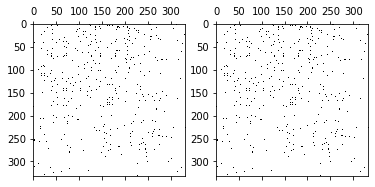

In [5]:
# generate the L matrix, assuming both weighted and unweighted input
L_weighted = cppLocalPageRank_weight(A_weighted, c=0.85, return_only_neighbours=True)
L = cppLocalPageRank(A, c=0.85, return_only_neighbours=True)

# convert to numpy matrix, to visually check the results
L_weighted_mat = list2matrix(L_weighted)
L_mat = list2matrix(L)

# plot the matrices' spy 
fig, axs = plt.subplots(1, 2)
axs[0].spy(L_weighted_mat)
axs[1].spy(L_mat)

# and print the difference to check that the same result was obtained
print("Difference between Local PageRank Computations:", np.linalg.norm(L_mat-L_weighted_mat))

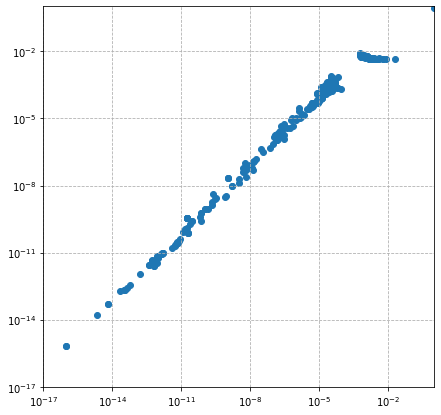

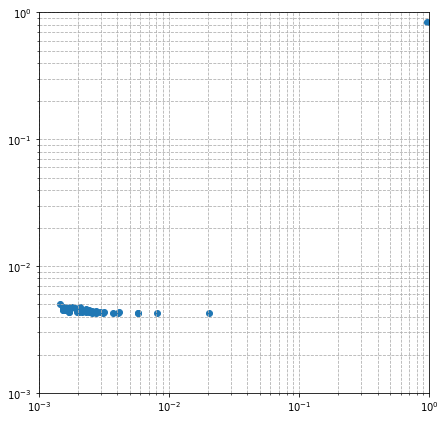

In [6]:
# now compute the approximate simrank to check the correctness of the algorithm
c = .85;
alpha = 2*c/(1+c);

#andersen's paper inverts alpha
alpha = 1-alpha;

# compute the linear system solution of the lazy pagerank
A_mat = list2matrix(A, False)

# compute the degree
d = np.dot(A_mat, np.ones((N, 1)))

# compute using fast algorithm
v = np.argmax(d)
p, r = cppApproximateSimrank(A, v, alpha, epsilon=1e-20, max_iters=10000, return_only_neighbours=False)
p = np.array(p)
p /= p.sum()

# compute W (lazy pagerank matrix): W = .5(I+M)
# where M = D^-1 * A
M = np.matmul(np.diagflat(1/d), A_mat)
W = .5*(np.eye(N)+M)

# initialize the teleportation vector
q = np.zeros((N, 1))
q[v] = 1

# compute the actual vector: p = alpha*W*p + (1 - alpha)q
p_s = np.dot(np.linalg.inv((np.eye(N)-alpha*W)/(1-alpha)), q).flatten()

# compute the residual's pagerank
p_r = np.dot(np.linalg.inv((np.eye(N)-alpha*W)/(1-alpha)), r).flatten()

# plot results
fig, axs = plt.subplots(1, 1, figsize=(7,7))
axs.scatter(p_s, p + p_r)
axs.set_yscale('log')
axs.set_xscale('log')
xl = [1e-17, 1]
yl = [1e-17, 1]
axs.set_xlim(xl)
axs.set_ylim(yl)
axs.grid(True, which="both", ls="--")

# plot results
fig, axs = plt.subplots(1, 1, figsize=(7,7))
axs.scatter(p_s, p)
axs.set_yscale('log')
axs.set_xscale('log')
xl = [1e-3, 1]
yl = [1e-3, 1]
axs.set_xlim(xl)
axs.set_ylim(yl)
axs.grid(True, which="both", ls="--")